In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import seaborn as sns

Delta Plot Year 2050

In [2]:
# ---- Read and Organize 2050 generation data ----
# Read date into a DataFrame, filter year
report = pd.read_excel('delta_gen.xlsx')
graph_data = pd.DataFrame(pd.pivot_table(data = report.loc[report.year == 2050], columns = 'tech', index = 'scenario', values = 'Generation (TWh)', aggfunc = 'sum', fill_value = 0))
# Get x-axis labels
x_scens = report['scenario'].unique()
graph_data = graph_data.reindex(index=x_scens)
graph_data.reset_index(inplace=True)

# Get tech list
tech_styles = pd.read_csv('gen_tech_style.csv')
tech_styles_dict = tech_styles.set_index(tech_styles.order)['color'].to_dict()

# Create dataframe for net cahnge 
net_change = pd.DataFrame(pd.pivot_table(data=report, columns='scenario', values='Net Level Generation (TWh)'))
net_change = pd.pivot_table(data=net_change, columns='Net Level Generation (TWh)')
net_change = net_change.reindex(index=x_scens)
net_change.reset_index(inplace=True)
net_change

,scenario,Net Level Generation (TWh)
0,BAU,0.886106
1,Decarb,4.939737
2,Low RE Costs,9.976501
3,High RE Costs,-6.511006
4,Reduced RE,-1.576437
5,No CCS,-40.901734
6,Low FC Costs,8.853923
7,High FC Costs,0.406069
8,High Electrification,-55.222106


In [3]:
# ---- Date Organization ----

graph_data['Nuclear'] = graph_data['nuclear'] + graph_data['nuclear-smr']
graph_data['Coal'] = graph_data['coal'] + graph_data['coal-ccs_mod_upgrade']
graph_data['Gas-CC'] = graph_data['gas-cc']
graph_data['Gas-CC CCS'] = graph_data['gas-cc-ccs_mod']+graph_data['gas-cc-ccs_mod_upgrade']
graph_data['Gas-CT'] = graph_data['gas-ct']
graph_data['Oil/Gas'] = graph_data['o-g-s']
graph_data['Other RE'] = graph_data['hydro'] + graph_data['geothermal'] + graph_data['biopower'] + graph_data['lfill-gas']
graph_data['Fuel Cell'] = graph_data['fuel-cell']
graph_data['H2-CT'] = graph_data['h2-ct'] + graph_data['h2-ct_upgrade']
graph_data['Onshore Wind'] = graph_data['wind-ons']
graph_data['Offshore Wind'] = graph_data['wind-ofs']
graph_data['Solar'] = graph_data['csp'] + graph_data['upv'] + graph_data['distpv']

graph_data=graph_data.drop(columns=['nuclear','nuclear-smr', 
                                    'coal','coal-ccs_mod_upgrade',
                                    'gas-cc','gas-cc-ccs_mod','gas-cc-ccs_mod_upgrade',
                                    'gas-ct', 'o-g-s', 'beccs_mod',
                                    'lfill-gas',
                                    'fuel-cell',
                                    'h2-ct','h2-ct_upgrade',
                                    'wind-ons', 'wind-ofs',
                                    'csp','upv','distpv',
                                    'hydro','geothermal','biopower',
                                    'battery_4','battery_8','pumped-hydro','Canada'])
graph_data

tech,scenario,Nuclear,Coal,Gas-CC,Gas-CC CCS,Gas-CT,Oil/Gas,Other RE,Fuel Cell,H2-CT,Onshore Wind,Offshore Wind,Solar
0,BAU,-2.940035,8.531755,-52.967279,-6.351039,-54.921017,-0.008614,-0.091053,108.027914,-13.029750,22.996848,-18.060096,20.572993
1,Decarb,-19.105721,9.391825,-3.226893,-26.736854,-1.763225,0.273514,1.398463,108.971022,-58.723172,-13.285421,-7.004530,-22.242808
2,Low RE Costs,0.000000,0.105558,10.231880,-49.193894,-3.935552,-0.079022,-2.892517,98.138266,-43.143209,86.383028,2.372581,-73.157188
3,High RE Costs,-22.556268,17.449616,-2.074720,-36.984259,-2.519654,-0.112953,-4.347138,128.915538,-74.614733,7.731389,-12.340698,-53.706118
4,Reduced RE,14.863677,31.301284,-3.801001,-35.748867,-2.565962,-0.262675,1.647961,116.624644,-66.611590,11.182853,-13.474877,-106.939919
5,No CCS,-52.679485,0.000000,0.000000,0.000000,0.000000,0.000000,-5.035304,192.455735,-151.818253,-22.004516,-4.675433,-60.308439
6,Low FC Costs,-12.490483,10.546803,-3.952874,-36.622779,-1.058107,0.027314,0.080541,119.973714,-60.113784,2.022045,-6.293708,-37.440928
7,High FC Costs,-18.114115,7.734161,-2.659470,-13.829203,-1.938726,0.300078,0.336063,90.777679,-55.364017,-51.098402,-5.029243,9.300400
8,High Electrification,8.421534,2.226646,-1.380468,4.496891,-8.619938,-0.982808,0.024204,190.594955,-134.165303,-123.083298,-29.122310,-65.288211


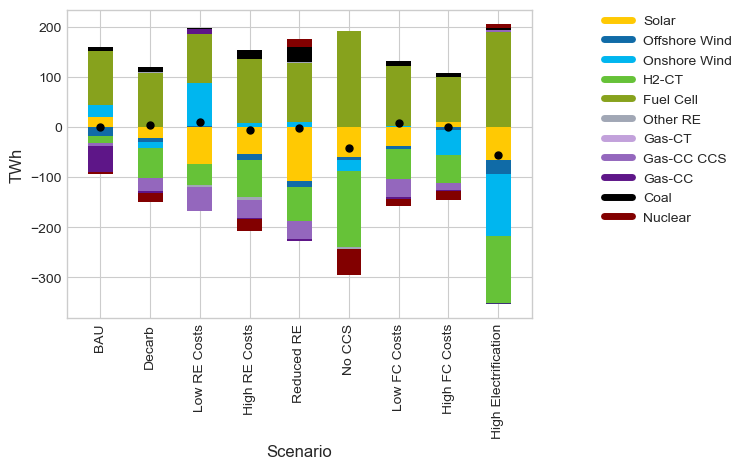

In [4]:
# ---- Plot 2050 delta generation ---
# Get tech list
y_categories = graph_data.columns.tolist()
y_categories.remove('scenario')
y_categories.reverse()

# Create lists to track stacking positions
running_sums_pos = [0]*len(x_scens)
running_sums_neg = [0]*len(x_scens)

# Initiate plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(1,1, figsize = (6,4),  sharex = True ) # , layout = 'constrained'

# Loop through each tech
for tech in y_categories:
    yvals = graph_data[tech].tolist()
    # Drop techs that have negligible values
    if abs(sum(yvals)) < 1:
        y_categories.remove(tech)
    bottoms = []
    # Update stacking positions
    for i in range(len(yvals)):
        if yvals[i] >=0:
            bottoms.append(running_sums_pos[i])
            running_sums_pos[i]+=yvals[i]
        else:
            bottoms.append(running_sums_neg[i])
            running_sums_neg[i]+=yvals[i]
    # Plot bars for teh current tech for each scenario
    axs.bar(x_scens,yvals, width = 0.5, bottom = bottoms, color = tech_styles.loc[tech_styles.order==tech]['color'])

# Customize plot
axs.set_ylabel('TWh', fontsize=12)
axs.set_xlabel('Scenario', fontsize=12)
plt.xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=90)

# Plot dots indicating net change
axs.scatter(x_scens, net_change['Net Level Generation (TWh)'], c='black', marker='o',s=25, label='Net Change Value')

# Customize legend
custom_lines = [Line2D([0], [0], color=tech_styles_dict[x], lw=5) for x in y_categories]
fig.legend(custom_lines, y_categories ,loc='upper left', bbox_to_anchor=(1,0.9), fontsize = 10)

Plot delta generation between two scenarios

In [5]:
# --- Read Data ---
# Read into a DataFrame, filter data
report = pd.read_excel('delta_gen.xlsx')
graph_data = report[(report['year'] >= 2026) &                               # filter years
                    (report['scenario'].isin(['Decarb']))]                  # filter scenario
graph_data = pd.DataFrame(pd.pivot_table(data = graph_data, columns = 'tech', index = ['scenario','year'], values = 'Generation (TWh)', aggfunc = 'sum', fill_value = 0))
graph_data.reset_index(inplace = True, drop = False)

# Get tech list
tech_styles = pd.read_csv('tech_styles.csv')
tech_styles_dict = tech_styles.set_index(tech_styles.order)['color'].to_dict()
graph_data

tech,scenario,year,Canada,battery_4,battery_8,beccs_mod,biopower,coal,coal-ccs_mod_upgrade,csp,...,h2-ct_upgrade,hydro,lfill-gas,nuclear,nuclear-smr,o-g-s,pumped-hydro,upv,wind-ofs,wind-ons
0,Decarb,2026,-0.003749,0.017221,0.000000,0.000000,0.000000e+00,-1.003555,0.000000,0,...,0.000000,0.141554,-0.000600,-0.277314,0.000000,-0.018219,0.094604,-1.252012,0.007643,-2.714277
1,Decarb,2029,-0.009758,0.072533,0.010727,0.000000,-1.456000e-07,0.689274,0.000000,0,...,0.000000,0.068586,-0.000804,-0.349712,0.000000,-0.018218,-0.016230,-4.928645,0.006076,-1.123724
2,Decarb,2032,-0.142647,-0.216786,-0.109674,0.000000,1.343522e-01,-2.637461,16.268232,0,...,0.000000,0.202320,0.036778,-0.853774,0.000000,0.004863,-0.011212,5.847946,-0.033389,-4.152894
3,Decarb,2035,-0.074277,0.998376,0.662620,0.001080,1.597887e-05,0.000000,11.829233,0,...,-7.529450,-0.885632,0.050648,0.607747,0.000000,-0.763889,1.895135,-12.679074,1.026676,-9.817933
4,Decarb,2038,-0.569450,1.680100,3.480219,0.004488,1.597887e-05,0.000000,11.380218,0,...,-7.651523,-0.205285,0.117122,2.998507,0.000000,0.319247,0.543986,-32.556147,1.243580,16.261993
5,Decarb,2041,0.200896,2.893708,7.996318,0.003405,1.597887e-05,0.000000,20.863001,0,...,-7.671701,0.020987,-0.034986,-0.684210,-17.022897,0.255942,-0.841376,-31.928996,5.395752,26.846837
6,Decarb,2044,0.568696,4.181116,11.377448,0.003363,-8.477580e-05,0.000000,7.123543,0,...,-9.652954,1.717953,-0.155551,0.730978,-17.838901,0.235722,-3.043019,-17.856732,-6.131898,39.883351
7,Decarb,2047,0.353429,4.309127,17.466684,0.009554,-8.477580e-05,0.013800,8.752440,0,...,-10.708607,2.844991,-0.019011,-0.863460,-19.761921,0.284471,-5.041229,-50.308089,-5.089292,61.197641
8,Decarb,2050,1.242666,1.008401,14.183557,0.007427,-8.477580e-05,-0.125924,9.517749,0,...,-9.745108,1.983298,0.226825,1.204453,-20.310174,0.273514,-4.287892,-22.242808,-7.004530,-13.285421


In [6]:
# ---- Data Organization ----

graph_data['Nuclear'] = graph_data['nuclear'] + graph_data['nuclear-smr']
graph_data['Coal'] = graph_data['coal'] + graph_data['coal-ccs_mod_upgrade']
graph_data['Gas-CC'] = graph_data['gas-cc']
graph_data['Gas-CC CCS'] = graph_data['gas-cc-ccs_mod']+graph_data['gas-cc-ccs_mod_upgrade']
graph_data['Gas-CT'] = graph_data['gas-ct']
graph_data['Oil/Gas'] = graph_data['o-g-s']
graph_data['Other RE'] = graph_data['hydro'] + graph_data['geothermal'] + graph_data['biopower'] + graph_data['lfill-gas']
graph_data['Fuel Cell'] = graph_data['fuel-cell']
graph_data['H2-CT'] = graph_data['h2-ct'] + graph_data['h2-ct_upgrade']
graph_data['Onshore Wind'] = graph_data['wind-ons']
graph_data['Offshore Wind'] = graph_data['wind-ofs']
graph_data['Solar'] = graph_data['csp'] + graph_data['upv'] + graph_data['distpv']

graph_data=graph_data.drop(columns=['nuclear','nuclear-smr', 
                                    'coal','coal-ccs_mod_upgrade',
                                    'gas-cc','gas-cc-ccs_mod','gas-cc-ccs_mod_upgrade',
                                    'gas-ct', 'o-g-s', 'beccs_mod',
                                    'lfill-gas',
                                    'fuel-cell',
                                    'h2-ct','h2-ct_upgrade',
                                    'wind-ons', 'wind-ofs',
                                    'csp','upv','distpv',
                                    'hydro','geothermal','biopower',
                                    'battery_4','battery_8','pumped-hydro','Canada'])
graph_data

tech,scenario,year,Nuclear,Coal,Gas-CC,Gas-CC CCS,Gas-CT,Oil/Gas,Other RE,Fuel Cell,H2-CT,Onshore Wind,Offshore Wind,Solar
0,Decarb,2026,-0.277314,-1.003555,4.203006,0.000000,-3.962912,-0.018219,0.096372,5.118946,0.000000,-2.714277,0.007643,-1.252012
1,Decarb,2029,-0.349712,0.689274,3.311629,0.000000,-3.967672,-0.018218,0.068387,8.391699,-2.018830,-1.123724,0.006076,-4.928645
2,Decarb,2032,-0.853774,13.630771,5.343919,-23.430011,-3.976627,0.004863,0.818672,9.979138,-2.018830,-4.152894,-0.033389,5.847946
3,Decarb,2035,0.607747,11.829233,-1.871369,-9.535419,0.882733,-0.763889,-0.981168,19.984179,-12.491311,-9.817933,1.026676,-12.679074
4,Decarb,2038,2.998507,11.380218,-2.260675,-13.034709,0.142618,0.319247,0.242423,29.428565,-14.276854,16.261993,1.243580,-32.556147
5,Decarb,2041,-17.707107,20.863001,-2.983075,-20.379905,0.155424,0.255942,-1.071890,57.588103,-27.174902,26.846837,5.395752,-31.928996
6,Decarb,2044,-17.107924,7.123543,-3.226893,-26.396390,2.058039,0.235722,3.007618,75.489685,-33.991936,39.883351,-6.131898,-17.856732
7,Decarb,2047,-20.625381,8.766240,-2.366796,-35.499850,-0.128345,0.284471,1.572485,100.813351,-43.687904,61.197641,-5.089292,-50.308089
8,Decarb,2050,-19.105721,9.391825,-3.226893,-26.736854,-1.763225,0.273514,1.398463,108.971022,-58.723172,-13.285421,-7.004530,-22.242808


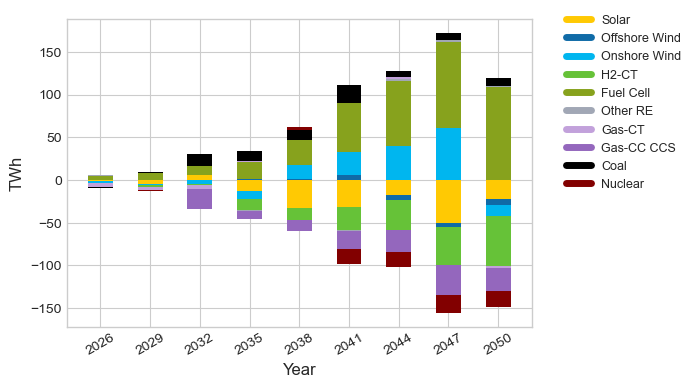

In [7]:
# --- Plotting ---

# Get tech list, drop techs with negligible values
y_categories = graph_data.columns.to_list()
y_categories = [y for y in y_categories if y not in ['scenario','year','x_id']]
for tech in y_categories:
    if abs(sum(graph_data[tech])) <5:
        y_categories.remove(tech)
y_categories.reverse()

# Initiate plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(1,1, figsize = (6,4),  sharex = True ) # , layout = 'constrained'

# Create lists to track stacking positions
running_sums_pos = [0]*len(x_scens)
running_sums_neg = [0]*len(x_scens)

# Get x-axis labels
yrs = graph_data.year.to_list()
for t in range(len(y_categories)):
    yvals = graph_data[y_categories[t]].tolist()
    bottoms = []
    # Update stacking positions
    for i in range(len(yvals)):
        if yvals[i] >=0:
            bottoms.append(running_sums_pos[i])
            running_sums_pos[i]+=yvals[i]
        else:
            bottoms.append(running_sums_neg[i])
            running_sums_neg[i]+=yvals[i]
    # Plot barrs for the current tech at each scenario
    axs.bar(yrs,yvals, width = 1.5, bottom = bottoms, color = tech_styles_dict[y_categories[t]])

# Customize plot
axs.set_ylabel('TWh', fontsize=12)
axs.set_xlabel('Year', fontsize=12)
plt.xticks(yrs, yrs,rotation=30, fontsize = 10)

# Set y limits
ymin = axs.get_ylim()[0]
ymax = axs.get_ylim()[1]
axs.set_ylim(ymin,ymax)

# Customize legend
custom_lines = [Line2D([0], [0], color=tech_styles_dict[x], lw=5) for x in y_categories]
axs.legend(custom_lines, y_categories ,loc='upper left', bbox_to_anchor=(1.050,1.05), fontsize = 9)